In [5]:
import requests
import pandas as pd
import hmac
import hashlib
from datetime import datetime
import numpy as np

In [6]:
import credentials
secret_bytes = bytes(credentials.secret , 'latin-1')

In [7]:
rates_request = requests.get("https://api.coinbase.com/v2/exchange-rates?currency=USD")
rates = pd.DataFrame.from_dict(rates_request.json()["data"])
rates = rates[["rates"]].astype(float).rename(columns={"rates": "rate"})
rates

,rate
1INCH,1.461988
AAVE,0.015193
ACH,82.179398
ADA,2.138809
AED,3.673100
...,...
ZEN,0.069493
ZMW,17.031341
ZRX,3.608363
ZWD,475.751200


In [8]:
def generate_access_sign(timestamp, method, requestPath, body):
    message = timestamp + method + requestPath + body
    message_bytes = bytes(message , 'latin-1')
    signature = hmac.new(secret_bytes, message_bytes, digestmod = hashlib.sha256).hexdigest()
    return signature

In [9]:
def coinbase_api(path):
    BASE = "https://api.coinbase.com"
    timestamp = str(round(datetime.now().timestamp()))
    signature = generate_access_sign(timestamp, "GET", path, "")
    HEADERS = {
        "CB-ACCESS-KEY": credentials.key,
        "CB-ACCESS-SIGN": signature,
        "CB-ACCESS-TIMESTAMP": timestamp,
        "CB-VERSION": "2022-05-15"
    }
    return requests.get(BASE+path, headers=HEADERS)

wallets_request = coinbase_api("/v2/accounts?limit=300")
# display(wallets_request.json())

In [10]:
assets = pd.DataFrame.from_dict(wallets_request.json()["data"])
assets["symbol"] = assets["balance"].apply(lambda balance: balance["currency"])
assets["balance"] = assets["balance"].apply(lambda balance: float(balance["amount"]))
assets = assets[["symbol", "balance", "id"]].set_index("symbol")

In [11]:
assets = assets.join(rates)
assets["balance"] = assets["balance"] / assets["rate"]

In [12]:
# Tidy up coinbase data
assets.rename(index={'CGLD':'CELO'}, inplace=True)
assets.drop(index="USD", inplace=True)

# Handle TLH replacements
assets.rename(index={
    "WBTC": "BTC",
    "YFI": "ETH",
    "BNT": "ETH",
    "BCH": "ETH",
}, inplace=True)
# assets = assets.groupby("symbol").agg({"balance": [np.sum], "id": list})
# assets.columns.droplevel()
# assets

assets = assets.groupby('symbol').agg(
    balance=('balance', 'sum'),
    wallets=('id', list)
)

In [13]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(assets)

In [14]:
mc_dicts = []
for page in range(1, 20):
    results = requests.get(f"https://api.coingecko.com/api/v3/coins/markets?vs_currency=usd&order=market_cap_desc&per_page=250&page={page}&sparkline=false").json()
    mc_dicts.extend(results)

In [15]:
mc = pd.DataFrame.from_dict(mc_dicts)
mc["symbol"] = mc["symbol"].str.upper()
mc.set_index("symbol", inplace=True)
mc = mc[["market_cap"]]
mc = mc[~(mc["market_cap"] == 0)]
# mc[mc.index.duplicated()].sort_index()


In [16]:
df = assets.join(mc)

In [17]:
weights = pd.read_csv('active_weights.csv', index_col="symbol")
weights["weight"] = pd.to_numeric(weights["weight"])
df = df.join(weights)

In [18]:
# Missing market caps
df[df["market_cap"].isnull()]

,balance,wallets,market_cap,weight
symbol,,,,
BTRST,0.0,[BTRST],NaN,NaN
LOOM,0.0,[d1e2d5dd-c742-55e5-a60b-5d20b8658568],NaN,NaN
MCO2,0.0,[MCO2],NaN,NaN
PAX,0.0,[PAX],NaN,0.0
SHPING,0.0,[SHPING],NaN,NaN


In [19]:
df = df[~df["market_cap"].isnull()]

In [20]:
# To be weighted
df[df["weight"].isnull()].sort_values("market_cap", ascending=False)[["market_cap", "weight"]]

,market_cap,weight
symbol,,
SUPER,39379345.00,NaN
AGLD,29216309.00,NaN
UNFI,29097202.00,NaN
BLZ,28938365.00,NaN
DIA,28101332.00,NaN
ALCX,26655829.00,NaN
ERN,21273697.00,NaN
GODS,17319484.00,NaN
QSP,16147063.00,NaN


<AxesSubplot:ylabel='Frequency'>

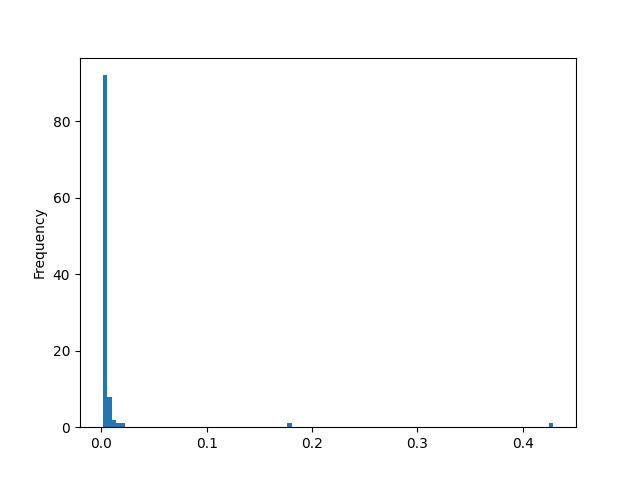

In [21]:
df = df[~df["weight"].isnull()]
df = df[~(df["weight"] == 0)]
df["custom_weighted_mc"] = df["market_cap"] * df["weight"]
df["custom_allocation_target"] = df["custom_weighted_mc"] / df["custom_weighted_mc"].sum()
df["log_custom_weighted_mc"] = np.log(df["custom_weighted_mc"])
df["log_custom_weighted_allocation_target"] = df["log_custom_weighted_mc"] / df["log_custom_weighted_mc"].sum()
log_weight = 0.3
df["fully_weighted_allocation_target"] = (df["log_custom_weighted_allocation_target"] * log_weight) + (df["custom_allocation_target"] * (1-log_weight))
%matplotlib widget
df["fully_weighted_allocation_target"].plot.hist(bins=100)

In [30]:
df["current_allocation"] = df["balance"] / df["balance"].sum()
df["target_allocation"] = df["fully_weighted_allocation_target"] * credentials.target_portfolio_size
df["delta"] = df["target_allocation"] - df["balance"]
# df[["balance", "fully_weighted_allocation_target", "target_allocation", "delta"]].sort_values("delta", ascending=False)

In [23]:

def get_latest_tx(row):
    transactions = []
    for id in row.wallets:
        tx_request = coinbase_api(f"/v2/accounts/{id}/transactions")
        transactions.extend(tx_request.json()["data"])
        # display(tx_request.content)

    if not transactions:
        return row

    # ridiculous coinbase doubled data problem
    transactions = pd.DataFrame.from_dict(transactions)
    # doubled_content = tx_request.text
    # import json
    # transactions = pd.DataFrame.from_dict(json.loads(doubled_content[:len(doubled_content)//2])["data"])

    transactions["timestamp"] = pd.to_datetime(transactions["updated_at"])
    transactions["symbol"] = row.name
    x = transactions.groupby(by=["type", "symbol"])[["timestamp"]].agg("max")
    x = x.reset_index(level="type")
    x = x.pivot(index=None, columns="type", values="timestamp")
    row["last_bought"] = x["buy"][0] if "buy" in x.columns else None
    row["last_sold"] = x["sell"][0] if "sell" in x.columns else None # TODO pandas idiomatic way to do all this
    return row


In [24]:
df = df.apply(get_latest_tx, axis='columns')

In [25]:
# df[["balance", "fully_weighted_allocation_target", "target_allocation", "delta"]].sort_values("delta", ascending=False)

In [26]:
df["last_sold"] = df["last_sold"].dt.tz_localize(None)
df["last_bought"] = df["last_bought"].dt.tz_localize(None)
beginning_of_window = np.datetime64(pd.Timestamp("now") - pd.Timedelta(days=31))

In [27]:
df["tlh_safe"] = (
    (df["delta"] < 0) & (df["last_bought"] < beginning_of_window)
) | (
    (df["delta"] > 0) & (df["last_sold"] < beginning_of_window)
)
tlh_safe = df[df["tlh_safe"]]

In [29]:
# tlh_safe[["balance", "fully_weighted_allocation_target", "target_allocation", "delta"]].sort_values("delta", ascending=False)